In [1]:
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp
# import hdf5storage # get code on https://pypi.python.org/pypi/hdf5storage/0.1.3
# import networkx as nx

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 写入mat
def WriteMatlab(data_np, VarName, FileName):
    matcontent = {}
    matcontent[VarName] = data_np
    hdf5storage.write(matcontent, filename=FileName, matlab_compatible=True)

In [4]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_6.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_10_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size doesn\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [5]:
# 参数设置

# 0. 公共参数
Monte_Carlo_loop = 10     # 蒙特卡洛模拟次数
time_steps = 50           # 总时间步数
N = network_scale_1[0]     # 网络节点数
w = 0.6                    # S-I断边概率
beta_list = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
             0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
             0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
             0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80, \
             0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.00]

# 1. SIS参数
# bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

# 4. 其他参数
aplha = 0.4      # 信息上传率
iter_ = 0

infective_count_average_total = np.zeros([time_steps])
awareness_count_average_total = np.zeros([time_steps])

In [6]:
for bata in beta_list:
    
    time_start_w = time.time()
    
    random.seed(512)
    np.random.seed(512)

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])


    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])



    time_start = time.time()

    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
        network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    a_1 = 1 - (1 - lamda) ** Num_neighbor_listener    # 最终计算的传播率
                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a_1:
                        Nodes_UAU[loop, t+1, i] = 1
                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


            # ----------更改连边----------
            for i in range(N):
                if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                    
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                    susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                    # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
                    neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

                    destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                    for infectNeighbor in neighbor_infective:
                        # 如果断边成功，则在当前时刻更改连接
                        if np.random.rand(1) <= w:
                            network_physical_t[t,i,infectNeighbor] = 0
                            network_physical_t[t,infectNeighbor,i] = 0

                            destination = random.choice(destinations)
                            destinations.remove(destination)

                            network_physical_t[t,i,destination] = 1
                            network_physical_t[t,destination,i] = 1

            # ----------SIS演化----------
            for i in range(N):

            # # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            # if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                if Nodes_SIS[loop, t, i] == 0:

                    neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                    # -----SIS感染过程1-----
                    # SIS感染率
                    v_1 = 1 - (1 - bata) ** Num_neighbor_infective
                    p = np.random.rand(1)
                    if p <= v_1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")

            # 将当前时间的接触网络复制到下一时刻
            network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

        # 保存本次蒙特卡洛循环产生的接触网络数据
        # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
        # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
        # name = 'loop_'+str(loop)
        # scio.savemat(addr, {name: network_physical_t})
        # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

        print("    loop {} - time has passed: {} ".format(loop, time.time()-time_start))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    awareness_count_average = np.mean(awareness_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

    infective_count_average_total[iter_] = (infective_count_average/N)[time_steps-1]
    awareness_count_average_total[iter_] = (awareness_count_average/N)[time_steps-1]
    iter_ += 1

    print("beta = {} - time has passed: {} ".format(bata, time.time()-time_start_w))

    loop 0 - time has passed: 62.657973766326904 
    loop 1 - time has passed: 126.86001467704773 
    loop 2 - time has passed: 188.04256224632263 
    loop 3 - time has passed: 250.49695253372192 
    loop 4 - time has passed: 314.84376096725464 
    loop 5 - time has passed: 376.8308415412903 
    loop 6 - time has passed: 437.7462110519409 
    loop 7 - time has passed: 498.3719308376312 
    loop 8 - time has passed: 559.155211687088 
    loop 9 - time has passed: 620.7534742355347 
w = 0.6 - time has passed: 620.7564771175385 
    loop 0 - time has passed: 61.359665632247925 
    loop 1 - time has passed: 121.62560439109802 
    loop 2 - time has passed: 182.01196336746216 
    loop 3 - time has passed: 241.93567633628845 
    loop 4 - time has passed: 302.65886545181274 
    loop 5 - time has passed: 364.70004868507385 
    loop 6 - time has passed: 425.09006786346436 
    loop 7 - time has passed: 485.2999722957611 
    loop 8 - time has passed: 545.3940980434418 
    loop 9 -

    loop 2 - time has passed: 111.60948777198792 
    loop 3 - time has passed: 148.53395891189575 
    loop 4 - time has passed: 185.7526240348816 
    loop 5 - time has passed: 222.91325283050537 
    loop 6 - time has passed: 260.0508635044098 
    loop 7 - time has passed: 297.0858383178711 
    loop 8 - time has passed: 334.23445558547974 
    loop 9 - time has passed: 371.6552577018738 
w = 0.6 - time has passed: 371.66025829315186 
    loop 0 - time has passed: 36.713332653045654 
    loop 1 - time has passed: 73.58276510238647 
    loop 2 - time has passed: 110.23245167732239 
    loop 3 - time has passed: 147.38307428359985 
    loop 4 - time has passed: 184.56671690940857 
    loop 5 - time has passed: 221.50519728660583 
    loop 6 - time has passed: 258.26055574417114 
    loop 7 - time has passed: 295.3304421901703 
    loop 8 - time has passed: 332.4180202484131 
    loop 9 - time has passed: 370.15002727508545 
w = 0.6 - time has passed: 370.1570291519165 
    loop 0 - t

    loop 4 - time has passed: 174.80594062805176 
    loop 5 - time has passed: 210.3514964580536 
    loop 6 - time has passed: 245.10791969299316 
    loop 7 - time has passed: 280.26621985435486 
    loop 8 - time has passed: 315.39549946784973 
    loop 9 - time has passed: 350.93705463409424 
w = 0.6 - time has passed: 350.943058013916 
    loop 0 - time has passed: 35.12427854537964 
    loop 1 - time has passed: 70.07297730445862 
    loop 2 - time has passed: 105.23728084564209 
    loop 3 - time has passed: 140.3335404396057 
    loop 4 - time has passed: 175.15161442756653 
    loop 5 - time has passed: 209.89964294433594 
    loop 6 - time has passed: 244.80477619171143 
    loop 7 - time has passed: 279.6412546634674 
    loop 8 - time has passed: 314.49935603141785 
    loop 9 - time has passed: 349.85978960990906 
w = 0.6 - time has passed: 349.86479234695435 
    loop 0 - time has passed: 35.3764443397522 
    loop 1 - time has passed: 70.41266393661499 
    loop 2 - tim

    loop 6 - time has passed: 195.171795129776 
    loop 7 - time has passed: 222.98522639274597 
    loop 8 - time has passed: 251.23874163627625 
    loop 9 - time has passed: 278.63990116119385 
w = 0.6 - time has passed: 278.64490580558777 
    loop 0 - time has passed: 27.486217737197876 
    loop 1 - time has passed: 56.42739701271057 
    loop 2 - time has passed: 85.32554650306702 
    loop 3 - time has passed: 112.62163662910461 
    loop 4 - time has passed: 140.80926704406738 
    loop 5 - time has passed: 169.01695942878723 
    loop 6 - time has passed: 196.52719020843506 
    loop 7 - time has passed: 223.8252832889557 
    loop 8 - time has passed: 251.26346635818481 
    loop 9 - time has passed: 278.90178298950195 
w = 0.6 - time has passed: 278.90678453445435 
    loop 0 - time has passed: 28.274739980697632 
    loop 1 - time has passed: 55.817301750183105 
    loop 2 - time has passed: 83.5466775894165 
    loop 3 - time has passed: 111.11294770240784 
    loop 4 - 

In [7]:
# plt.plot(infective_count_average/N, color='blue', label='SIS')
# plt.plot(awareness_count_average/N, color='green', label='UAU')

In [8]:
addr = '../../results/'
name1 = 'BA_WS_beta_infective'
name2 = 'BA_WS_beta_awareness'
scio.savemat(addr+name1+'.mat', {name1: infective_count_average_total})
scio.savemat(addr+name2+'.mat', {name2: awareness_count_average_total})

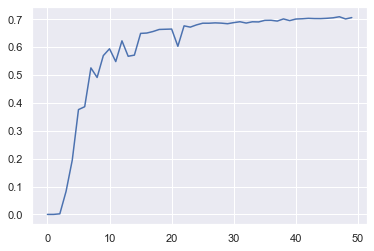

In [9]:
plt.plot(infective_count_average_total)